In [30]:
# 1. Set-up
# 가장 먼저, 패키지(라이브러리)들을 import 해보겠습니다.

# 우리가 이번 프로젝트에서 사용할 패키지 목록입니다.
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [31]:
# 앞으로 필요한 변수들을 생성합니다.
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


In [32]:
# 2. 데이터 가져오기
# import를 했으니 데이터를 가져와 보겠습니다. 데이터를 열어보면 이미 train, val(validation), test 로 나누어져 있습니다. 
# 열어보셨으면 이제 각 데이터들의 개수를 한번 체크해보죠.

# 아래와 같은 구조의 디렉토리에 이미지 파일들이 각각 담겨있습니다.
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [33]:
# train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있습니다.

# 개수 비는 89%, 10.7%, 0.3% 입니다. val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보겠습니다.

# train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할하겠습니다.

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [34]:
# 이제 train은 4185개, test는 624개, val은 1047개가 되었습니다. test_size를 수정하면 개수는 달라질 수 있습니다.

# train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 한번 보겠습니다.

# 정상 이미지와 폐렴 이미지를 구분해야 하는데 다행히도 파일 경로에 힌트가 있네요

print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [35]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다. 
# 또한, 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [36]:
# 결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다. 
# 우리가 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 합니다. 
# 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다. test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 
# 없으므로 imbalance한 데이터 셋이어도 문제없습니다.

# tf.data 인스턴스를 만들어 봅시다. tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해 줍니다.

# mini-batch는 왜 사용하는가?

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [37]:
# Train 데이터셋, validation 데이터셋 개수 확인을 해보겠습니다.

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [38]:
# 현재 이미지에는 라벨 데이터가 따로 없습니다.
# 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [39]:
# 원본 데이터 TypeCheck
element_spec = train_list_ds.element_spec
print(element_spec)

TensorSpec(shape=(), dtype=tf.string, name=None)


In [40]:
#Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
])

In [41]:
# 이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높습니다.
# 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여봅시다.
# decode_img 함수와 process_path 함수를 만들겠습니다.

# process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다. 
# get_label을 이용해서 라벨 값을 가져옵니다.

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [42]:
# train 데이터 셋과 validation 데이터 셋을 만듭니다. 
# num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 즐 수 있습니다.

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [43]:
# 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인해봅시다.

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [44]:
# 사이즈가 잘 변환되어 있고 라벨도 잘 들어가 있군요! 참고로, 코드에서 train_ds.take(1)은 하나의 데이터만 가져온다는 의미입니다.

# 위에서 train과 validation 데이터셋을 만든 것처럼 test 데이터셋도 만들어 보겠습니다. 그리고 데이터 개수도 확인해보겠습니다.

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [45]:
# Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다. 
# tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환시켜주겠습니다.

# shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.

# repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 
# 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.
# 예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.

# batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.
# 예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.

# prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 
# CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

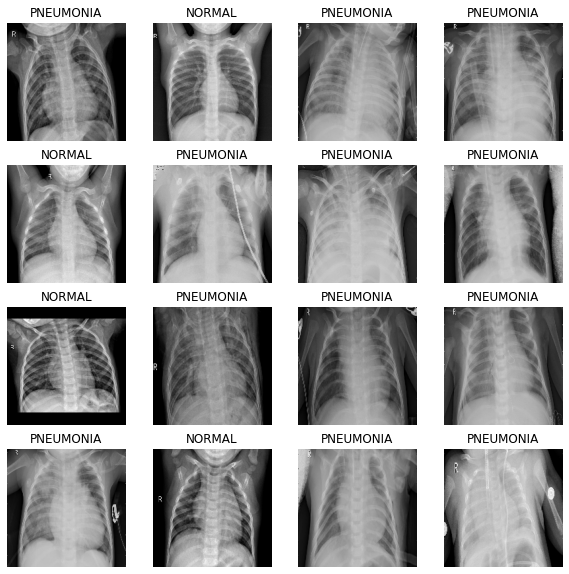

In [46]:
# 3. 데이터 시각화
# 데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출합니다. 
# 추출된 배치를 image와 label 데이터 셋으로 나눕니다. 이제 show_batch() 함수를 이용해서 결과 사진을 보겠습니다.

# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [47]:
# 4. ResNet Modeling (origin model : CNN Modeling)

# ResNet Modeling (risidual module)
# ResNet Skip_connection architecture, 참고 블로그 보니 identity 라고 하고 이미지에서 skip x를 identity라 함!
# 구조 : identity_block(skip connection), ReseNet_block
# 구조 : Conv layer 3개(64), 4개(128), 6개(256), 5개(512)
# 구조 : input 7x7(64)+ padding='same' + pooling, channel /2 pooling
# 구조 : 2개 Conv + identity(skip)
# 구조 : avg pool + FC(1000)

def identity_block(X, f, filters):
    X_shortcut = X

    # First component of main path & BottleNeck (1x1)
    X = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=1, padding='valid')(X)
    X = tf.keras.layers.BatchNormalization(axis=3)(X)
    X = tf.keras.layers.Activation('relu')(X)

    # Second component of main path
    X = tf.keras.layers.Conv2D(filters, kernel_size=f, strides=1, padding='same')(X)
    X = tf.keras.layers.BatchNormalization(axis=3)(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    # Third component of main path
    X = tf.keras.layers.Conv2D(filters, kernel_size=f, strides=1, padding='same')(X)
    X = tf.keras.layers.BatchNormalization(axis=3)(X)
    X = tf.keras.layers.Activation('relu')(X)

    # Final step: Add shortcut value to main path
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)

    return X

In [48]:
# ResNet Main_layers architecture

def ResNet18(input_shape=(180, 180, 3)):
    X_input = tf.keras.layers.Input(input_shape)

    # Initial conv layer
    X = tf.keras.layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(X_input)
    X = tf.keras.layers.BatchNormalization(axis=3)(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(X)

    # Stage 1 (64 channels, 3 layers)
    X = identity_block(X, f=3, filters=64)
    X = identity_block(X, f=3, filters=64)
    X = identity_block(X, f=3, filters=64)
    X = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(X)

    # Stage 2 (128 channels, 4 layers)
    X = identity_block(X, f=3, filters=128)
    X = identity_block(X, f=3, filters=128)
    X = identity_block(X, f=3, filters=128)
    X = identity_block(X, f=3, filters=128)
    X = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(X)

    # Stage 3 (256 channels, 6 layers)
    X = identity_block(X, f=3, filters=256)
    X = identity_block(X, f=3, filters=256)
    X = identity_block(X, f=3, filters=256)
    X = identity_block(X, f=3, filters=256)
    X = identity_block(X, f=3, filters=256)
    X = identity_block(X, f=3, filters=256)
    X = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(X)

    # Stage 4 (512 channels, 5 layers)
    X = identity_block(X, f=3, filters=512)
    X = identity_block(X, f=3, filters=512)
    X = identity_block(X, f=3, filters=512)
    X = identity_block(X, f=3, filters=512)
    X = identity_block(X, f=3, filters=512)
    X = tf.keras.layers.GlobalAveragePooling2D((2, 2), strides=None)(X)
    
    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(units=2, activation='sigmoid')(X)  # 예를 들어, CIFAR-10의 경우 10으로 설정

    return X_input, X

# Create model
input_shape = (180,180,3)
model = tf.keras.models.Model(input_shape, name='ResNet18')

In [49]:
# 5. 데이터 imbalance 처리
# imbalance 처리
# Weight balaning technic 처음 봄(기억!)
# train data에서 특정 class에 큰 가중치를 주어서 balance 맞추는 기법
# 0 : 정상, 1: 폐렴

# 서로 클래스 건수에 반비례하게 설정하는 코드
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [50]:
# 6. 모델 훈련
#ca llbacks: earlystopping, lr_schedule Setting

from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Early Stopping Callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Learning Rate Scheduler
## epoch 5 step 마다 lr 절반씩 감소 (local feature 추출에서는 작은 학습률이 도움 된다고 들었음)
def learning_rate_scheduler(epoch, learning_rate):
    if epoch%5 == 0:
        return learning_rate * 0.5
    else:
        return learning_rate

lr_scheduler_callback = LearningRateScheduler(learning_rate_scheduler)

In [51]:
# GPU 사용 설정 : 코랩에서만 해서 처음 보는 코드 (기억!)
## learning_rate_scheduler 추가

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
        loss='binary_crossentropy',
        metrics=METRICS
    )

NameError: name 'build_model' is not defined

In [ ]:
# 파라미터들을 대입하고 모델 fit

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[early_stopping_callback, lr_scheduler_callback] 
        ## callbacks 추가
    )

In [ ]:
# 7. 결과 확인
# 시각화 precision, recall, acc, loss

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])


In [24]:
# 테스트 데이터로 모델 평가를 해보겠습니다.

# 모델 평가를 위해 loss, accuracy, precision, recall 값을 출력해보겠습니다.

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')


39/39 [==============================] - 5s 122ms/step - loss: 1.1084 - accuracy: 0.6923 - precision: 0.6701 - recall: 1.0000
Loss: 1.1084249019622803,
Accuracy: 0.692307710647583,
Precision: 0.6701030731201172,
Recall: 1.0


* 회고 
